# Image Classification: Transfer Learning on the Stanford 40 Action Dataset

## Imports

In [1]:
! pip install torchinfo

In [2]:
import re
import os
import shutil
import random
import time

import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import (Subset,
                              Dataset,
                              DataLoader)
from torch.nn import functional as F
from torchvision import datasets, models, transforms
from torchinfo import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

From local files

In [3]:
from evaluation import compute_accuracy, compute_accuracy_loss
from train import train_model
from plotting import plot_random_images, plot_loss_accuracy

## Variables

In [24]:
IMAGE_SIZE = 256
NUM_EPOCHS = 20
BATCH_SIZE = 256
TEST_SIZE = 0.2
VAL_SIZE = 0.2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
DEVICE

device(type='cuda')

## Data Loading

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
base_dir = '/content/drive/My Drive/'

task_folder = base_dir +  "Stanford-40-Actions/"
organized_folder = task_folder + "Grouped-Images/"

In [ ]:
# Checking that dataset was uploaded correctly
total = 0

for dirname in os.listdir(organized_folder):
    num = len([fname for fname in os.listdir(os.path.join(organized_folder, dirname)) if fname.endswith(".jpg")])
    print(dirname, "number of images:", num)
    total += num

print("\nTotal number of images:", total)

washing_dishes number of images: 182
watching_TV number of images: 223
waving_hands number of images: 210
writing_on_a_board number of images: 183
writing_on_a_book number of images: 246
throwing_frisby number of images: 202
using_a_computer number of images: 230
looking_through_a_microscope number of images: 191
looking_through_a_telescope number of images: 203
walking_the_dog number of images: 293
shooting_an_arrow number of images: 214
smoking number of images: 241
taking_photos number of images: 197
texting_message number of images: 193
riding_a_bike number of images: 293
riding_a_horse number of images: 296
rowing_a_boat number of images: 185
running number of images: 251
playing_violin number of images: 260
pouring_liquid number of images: 200
pushing_a_cart number of images: 235
reading number of images: 245
fixing_a_car number of images: 251
holding_an_umbrella number of images: 292
jumping number of images: 295
playing_guitar number of images: 289
feeding_a_horse number of ima

## Exploring the images

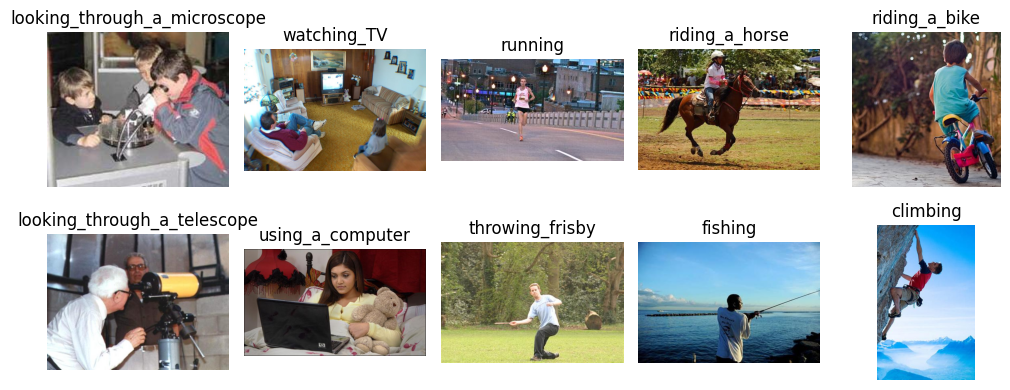

In [10]:
random.seed(42)
class_folders = os.listdir(organized_folder)

# Select 10 random classes to print
random_classes = random.sample(class_folders, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))

for i, class_name in enumerate(random_classes):
    class_path = os.path.join(organized_folder, class_name)
    class_images = os.listdir(class_path)

    random_image = random.choice(class_images)
    image_path = os.path.join(class_path, random_image)

    img = imread(image_path)
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].set_title(class_name)
    axes[i // 5, i % 5].axis('off')

plt.tight_layout()
plt.show()


## Dataset

### Applying transformations for data augmentation

In [8]:
train_transform = A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                             A.HorizontalFlip(p = 0.6),
                             A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                             A.CoarseDropout(min_holes=1, max_holes=3, max_height = 16, max_width = 16, p=0.3),
                             A.RGBShift(r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=0.5),
                             A.RandomBrightnessContrast(p=0.5),
                             A.GaussianBlur(blur_limit=(3, 5), p=0.4),
                             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                             ToTensorV2()])

test_transform = A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ToTensorV2()])

In [9]:
# Class to help using Albumentation library along with ImageFolder
class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

Dividing the dataset into training and testing parts

In [10]:
train_dataset = datasets.ImageFolder(organized_folder, transform=Transforms(train_transform))
test_dataset = datasets.ImageFolder(organized_folder, transform=Transforms(test_transform))

In [11]:
CLASSES = train_dataset.classes
print(CLASSES)

['applauding', 'blowing_bubbles', 'brushing_teeth', 'cleaning_the_floor', 'climbing', 'cooking', 'cutting_trees', 'cutting_vegetables', 'drinking', 'feeding_a_horse', 'fishing', 'fixing_a_bike', 'fixing_a_car', 'gardening', 'holding_an_umbrella', 'jumping', 'looking_through_a_microscope', 'looking_through_a_telescope', 'phoning', 'playing_guitar', 'playing_violin', 'pouring_liquid', 'pushing_a_cart', 'reading', 'riding_a_bike', 'riding_a_horse', 'rowing_a_boat', 'running', 'shooting_an_arrow', 'smoking', 'taking_photos', 'texting_message', 'throwing_frisby', 'using_a_computer', 'walking_the_dog', 'washing_dishes', 'watching_TV', 'waving_hands', 'writing_on_a_board', 'writing_on_a_book']


In [12]:
torch.manual_seed(42)
indices = torch.randperm(len(train_dataset))

test_size = int(TEST_SIZE * len(train_dataset))
val_size = int(VAL_SIZE * len(train_dataset))

train_dataset = Subset(train_dataset, indices[:-(val_size + test_size)])
val_dataset = Subset(test_dataset, indices[-(val_size + test_size):-test_size])
test_dataset = Subset(test_dataset, indices[-test_size:])

In [17]:
print("Train Dataset: ", len(train_dataset))
print("Train Dataset: ", len(val_dataset))
print("Train Dataset: ", len(test_dataset))

Train Dataset:  5720
Train Dataset:  1906
Train Dataset:  1906


Checking that we have all classes in validation and test sets

In [18]:
len(set([test_dataset.dataset.targets[i] for i in test_dataset.indices]))

40

In [19]:
len(set([val_dataset.dataset.targets[i] for i in val_dataset.indices]))

40

### Dataloaders

In [13]:
trainloader = DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=BATCH_SIZE)
valloader = DataLoader(val_dataset, shuffle=True, num_workers=2, batch_size=BATCH_SIZE)
testloader = DataLoader(test_dataset, shuffle=True, num_workers=2, batch_size=BATCH_SIZE)

### Showing train transformations applied to a random image from our data

In [22]:
show_transform = A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                             A.HorizontalFlip(p = 0.6),
                             A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                             A.CoarseDropout(min_holes=1, max_holes=3, max_height = 16, max_width = 16, p=0.3),
                             A.RGBShift(r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=0.5),
                             A.RandomBrightnessContrast(p=0.5),
                             A.GaussianBlur(blur_limit=(3, 5), p=0.4)])

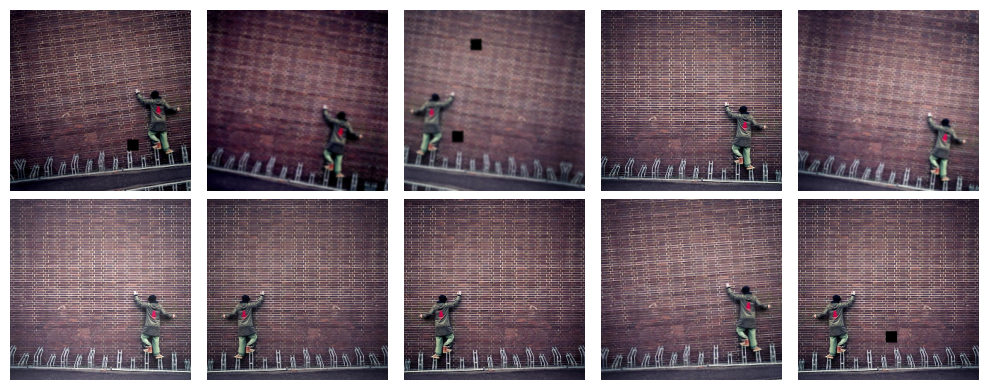

In [23]:
random.seed(42)

samples = 10

random_class = random.choice(os.listdir(organized_folder))
class_path = os.path.join(organized_folder, class_name)
class_images = os.listdir(class_path)
random_image = random.choice(class_images)
image_path = os.path.join(class_path, random_image)

image = imread(image_path)


figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i in range(samples):
    transformed_image = show_transform(image=image)["image"]
    axes[i // 5, i % 5].imshow(transformed_image)
    axes[i // 5, i % 5].axis('off')
plt.tight_layout()
plt.show()

### Showing train and test sets' images

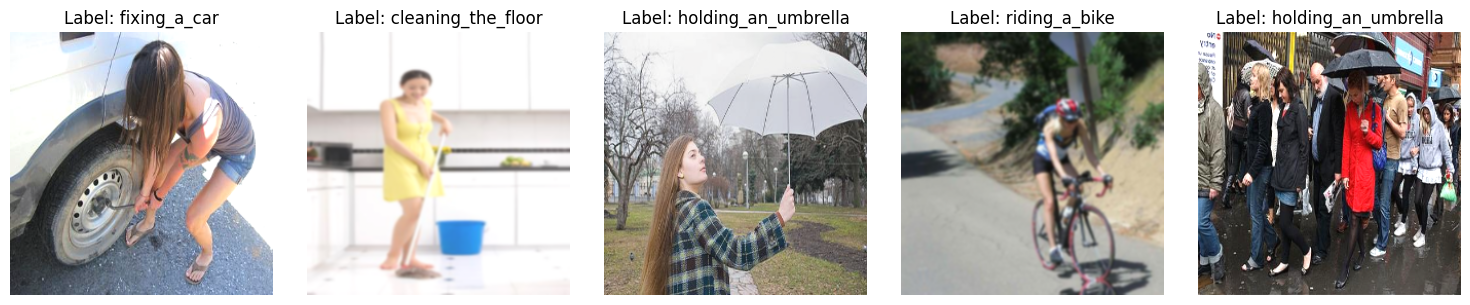

In [14]:
np.random.seed(42)
plot_random_images(train_dataset, classes=CLASSES)

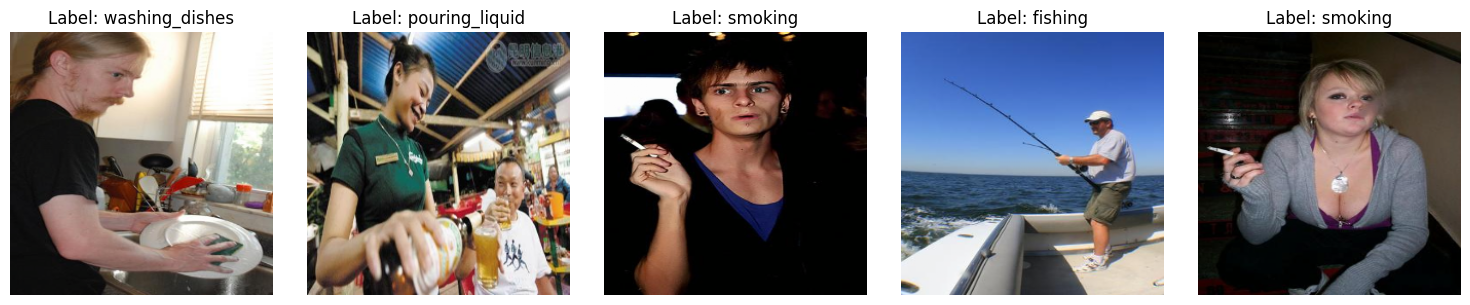

In [15]:
np.random.seed(42)
plot_random_images(val_dataset, classes=CLASSES)

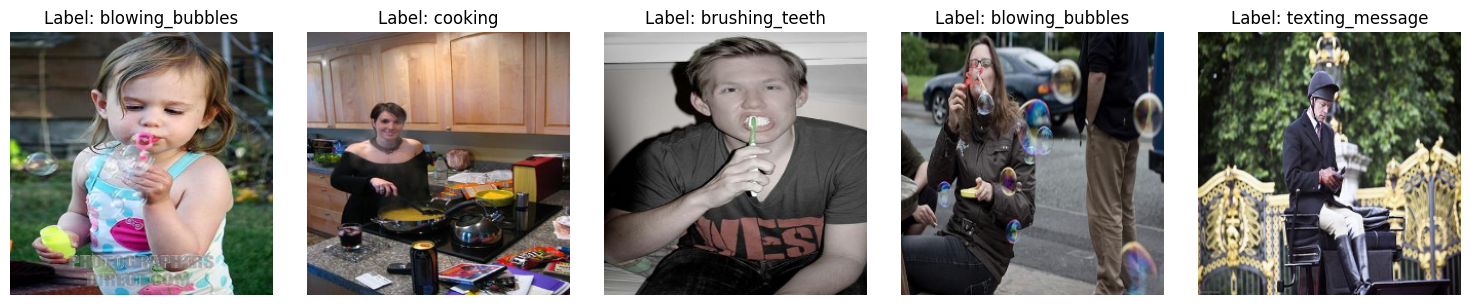

In [16]:
np.random.seed(42)
plot_random_images(test_dataset, classes=CLASSES)

## Fine-Tuning the pretrained model: ResNet-18

In [25]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(CLASSES))
model_ft = model_ft.to(DEVICE)

In [26]:
for name, param in model_ft.named_parameters():
    if name == 'fc.weight' or name == 'fc.bias':
      param.requires_grad = True
    else:
      param.requires_grad = False

In [27]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                factor=0.1,
                                                patience = 2,
                                                mode='max',
                                                verbose=True)

In [28]:
summary(model_ft, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [256, 40]                 --
├─Conv2d: 1-1                            [256, 64, 128, 128]       (9,408)
├─BatchNorm2d: 1-2                       [256, 64, 128, 128]       (128)
├─ReLU: 1-3                              [256, 64, 128, 128]       --
├─MaxPool2d: 1-4                         [256, 64, 64, 64]         --
├─Sequential: 1-5                        [256, 64, 64, 64]         --
│    └─BasicBlock: 2-1                   [256, 64, 64, 64]         --
│    │    └─Conv2d: 3-1                  [256, 64, 64, 64]         (36,864)
│    │    └─BatchNorm2d: 3-2             [256, 64, 64, 64]         (128)
│    │    └─ReLU: 3-3                    [256, 64, 64, 64]         --
│    │    └─Conv2d: 3-4                  [256, 64, 64, 64]         (36,864)
│    │    └─BatchNorm2d: 3-5             [256, 64, 64, 64]         (128)
│    │    └─ReLU: 3-6                    [256, 64, 64, 64] 

In [29]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list = [], [], [], []
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model_ft,
    num_epochs= NUM_EPOCHS,
    train_loader=trainloader,
    valid_loader=valloader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler)

Epoch: 001/020 | Train Loss: 3.3419 | Validation Loss: 2.8043
| Train Accuracy: 36.35% | Validation Accuracy: 37.09%
Time elapsed: 1.23 min
Epoch: 002/020 | Train Loss: 2.5508 | Validation Loss: 2.1702
| Train Accuracy: 52.95% | Validation Accuracy: 55.93%
Time elapsed: 2.42 min
Epoch: 003/020 | Train Loss: 2.0734 | Validation Loss: 1.7930
| Train Accuracy: 59.90% | Validation Accuracy: 62.75%
Time elapsed: 3.62 min
Epoch: 004/020 | Train Loss: 1.7768 | Validation Loss: 1.5728
| Train Accuracy: 62.59% | Validation Accuracy: 63.80%
Time elapsed: 4.83 min
Epoch: 005/020 | Train Loss: 1.5958 | Validation Loss: 1.4307
| Train Accuracy: 64.51% | Validation Accuracy: 65.06%
Time elapsed: 6.00 min
Epoch: 006/020 | Train Loss: 1.4739 | Validation Loss: 1.3345
| Train Accuracy: 66.61% | Validation Accuracy: 67.21%
Time elapsed: 7.22 min
Epoch: 007/020 | Train Loss: 1.3805 | Validation Loss: 1.2502
| Train Accuracy: 66.35% | Validation Accuracy: 68.05%
Time elapsed: 8.41 min
Epoch: 008/020 | Tra

Saving the fine-tuned model

In [30]:
torch.save(model_ft, task_folder + 'resnet18-ft.pth')

### Training results

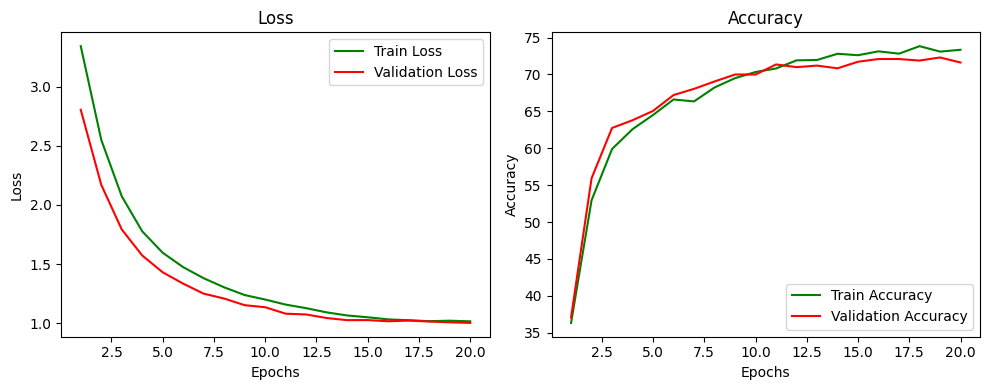

In [31]:
plot_loss_accuracy(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list)

## Evaluate

In [33]:
loaded_model = torch.load(task_folder+'resnet18-ft.pth')
loaded_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
acc = compute_accuracy(loaded_model, testloader, device="cuda").item()
print(f"Accuracy on the test set: {acc :.1f}%")

Accuracy on the test set: 70.3%


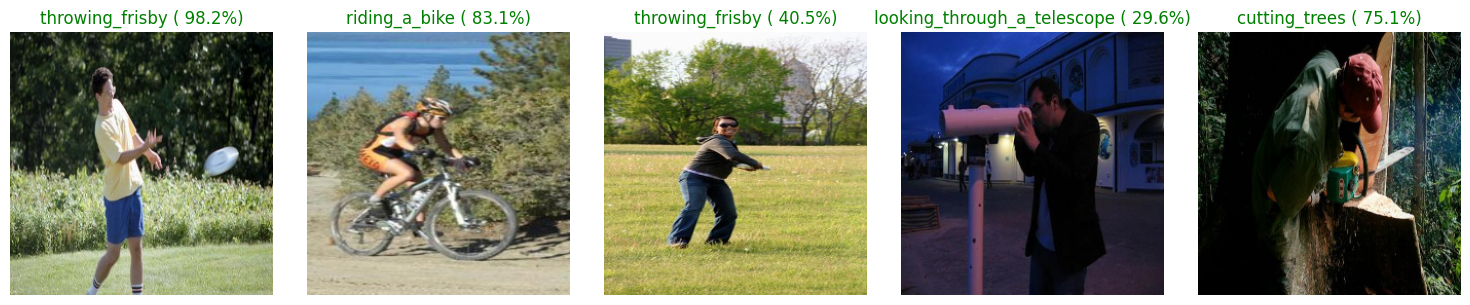

In [35]:
plot_random_images(test_dataset, classes= CLASSES, model=loaded_model, device="cuda", num_images=5)

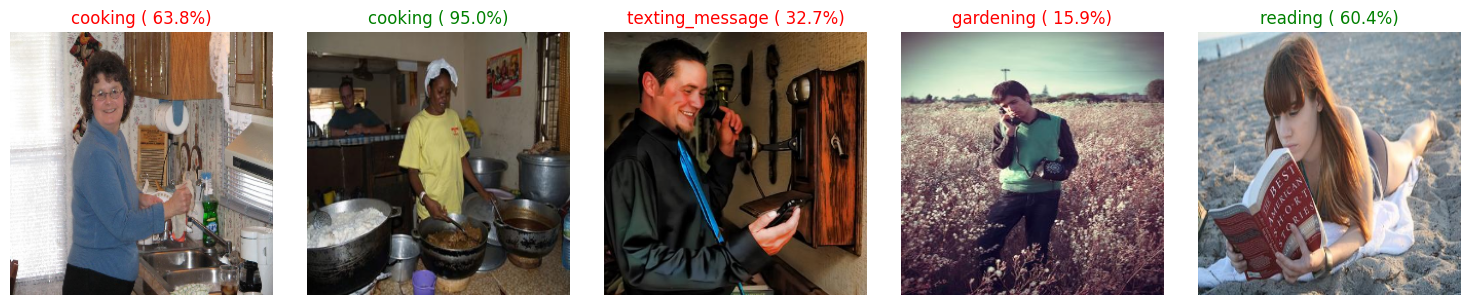

In [36]:
plot_random_images(test_dataset, classes= CLASSES, model=loaded_model, device="cuda", num_images=5)

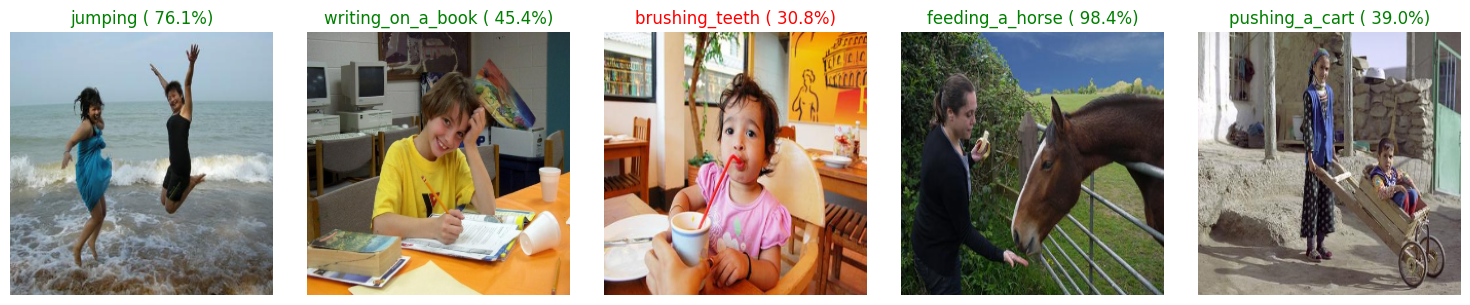

In [40]:
plot_random_images(test_dataset, classes= CLASSES, model=loaded_model, device="cuda", num_images=5)